# Neighborhood and Venues Data Analysis of Vancouver

## A. Introduction/Business Problem

### A.1. Description of the problem and a discussion of the background

Vancouver is a coastal seaport city in western Canada, located in the Lower Mainland region of British Columbia. As the most populous city in the province, the 2016 census recorded 631,486 people in the city, up from 603,502 in 2011. The Greater Vancouver area had a population of 2,463,431 in 2016, making it the third-largest metropolitan area in Canada. Vancouver has the highest population density in Canada, with over 5,400 people per square kilometer, which makes it the fifth-most densely populated city with over 250,000 residents in North America.Vancouver has been called a "city of neighborhoods. Each neighborhood in Vancouver has a distinct character and ethnic mix.

In this project, we will try to find an optimal location for a Cofee Shop. Specifically, this report will be targeted to investors interested in opening a Coffee Shop in Vancouver, Canada.

Since there are lots of cafes in Vancouver we will try to detect locations that are less crowded with coffee shops. We are also particularly interested in areas with no coffee shops in the vicinity. Also, locations as close as possible to the city center are preferred, assuming that the first two conditions are met. On the other hand, we will check each Borough through the number of universities and colleges due to the fact that college and university students are the potential target market for cafes.


### B. Data 
#### B.1. Data Description

According to the problems we need to obtain following information :

* We need a list of all $Boroughs$ and $Neighborhoods$ of Vancouver with $latitude$ and $longitude$ information. 
 * To obtain this information we use web scraping technique from several sources such as Wikipedia .
 
 
* **Forsquare API** to explore the neighbors of Vancouver and segment them by type of most common running businesses .


* Coordinate of Vancouver center and neighbors will be obtained using **GeoPy**.  

#### B.2. Data collection
##### Getting list of neighborhoods in Vancouver 

Firstly, we need to obtain a list of all official neighbors in Vancouver, which is available on Wikipedia.     
Web Scraping method is utilized here to achieve this goal.

In [45]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib.pyplot as plt
%matplotlib inline

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library



In [5]:
!pip install beautifulsoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup


     |████████████████████████████████| 112kB 30.9MB/s eta 0:00:01


In [6]:
url = "https://en.wikipedia.org/wiki/List_of_neighbourhoods_in_Vancouver"
html = urlopen(url)
source = requests.get(url)
soup = BeautifulSoup(html, "html5lib")

table = soup.find( 'div' ,  class_ = "mw-parser-output" )
#print(table.prettify())


Extract a list of Neighborhoods :

In [7]:
neigh_list = []
for ul in table.find_all('ul'):
    row = ""
    for li in ul.find_all('li'):
        neigh = li.text 
        neigh_list.append(neigh)
        
neigh = neigh_list[8:30]          
neigh

['Arbutus ridge',
 'Downtown',
 'Dunbar-Southlands',
 'Fairview',
 'Grandview-Woodland',
 'Hastings-Sunrise',
 'Kensington-Cedar Cottage',
 'Kerrisdale',
 'Killarney',
 'Kitsilano',
 'Marpole',
 'Mount Pleasant',
 'Oakridge',
 'Renfrew-Collingwood',
 'Riley Park',
 'Shaughnessy',
 'South Cambie',
 'Strathcona',
 'Sunset',
 'Victoria-Fraserview',
 'West end',
 'West Point Grey']

In [10]:
lat=[]
lng=[]
for n in list(range(0,len(neigh))) :

    address = '{} , Vancouver, Canada'.format(neigh[n])

    geolocator = Nominatim(user_agent="ca_explorer")
    location = geolocator.geocode(address)
    lat.append(location.latitude)
    lng.append(location.longitude)


Merge all data to one dataframe :

In [12]:
df = pd.DataFrame({'Neighborhood': neigh,
                   'Latitude' : lat,
                   'Longitude' : lng})
df.head()

,Neighborhood,Latitude,Longitude
0,Arbutus ridge,49.240968,-123.167001
1,Downtown,49.283393,-123.117456
2,Dunbar-Southlands,49.253460,-123.185044
3,Fairview,49.264113,-123.126835
4,Grandview-Woodland,49.270559,-123.067942


Visualizing Neighborhood of Vancouver using $Folium$  :

In [13]:
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

geolocator = Nominatim(user_agent="ca_explorer")
va_loc = geolocator.geocode('Vancouver, Canada')
# create map of New York using latitude and longitude values
map_vancouver = folium.Map(location=[va_loc.latitude, va_loc.longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_vancouver)  
    
map_vancouver

### Foursquare

Now that we have our location, let's use $Foursquare API$ to get info on coffee shops in each neighborhood with the limit as<p><em><strong>100 venue</strong> and the <em><strong>radius 1000 meter</strong> .

We're interested in venues in Coffee Shop, Cafeteria , Cafe etc. categories. So we will include in out list only venues that have 'coffee'  or 'cafe' in category name.

###### Category IDs corresponding to Italian restaurants were taken from Foursquare web site (https://developer.foursquare.com/docs/resources/categories):



* 4bf58dd8d48988d1e0931735 Coffee Shop

* 4bf58dd8d48988d128941735 Cafeteria

* 4bf58dd8d48988d16d941735 Cafe

* 5665c7b9498e7d8a4f2c0f06 Corporate Coffee Shop

In [17]:
CLIENT_ID = 'HUWPD5CQRGYRKTILP0F0JQLE2BZ1KMAAMXQCI3BQAXJQ3GBG' # your Foursquare ID
CLIENT_SECRET = 'AG3RQ0MOKOMNV5PNHWK3YM0K4RAYCP04DYXMBDNXMH3O2UFV' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CATEGORIES = ['4bf58dd8d48988d1e0931735','4bf58dd8d48988d128941735',
              '4bf58dd8d48988d16d941735','5665c7b9498e7d8a4f2c0f06' ]
RADIUS = '1000'
LIMIT = '100'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HUWPD5CQRGYRKTILP0F0JQLE2BZ1KMAAMXQCI3BQAXJQ3GBG
CLIENT_SECRET:AG3RQ0MOKOMNV5PNHWK3YM0K4RAYCP04DYXMBDNXMH3O2UFV




Getting the data of the first neighborhood (Arbutus ridge) to get familiar with the data structure of API :

In [21]:
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                '49.240968', 
                '-123.167001',
                CATEGORIES[0],
                RADIUS, 
                LIMIT)
results = requests.get(url).json()
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head()

,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,venue.location.distance,venue.location.postalCode,venue.location.cc,venue.location.city,venue.location.state,venue.location.country,venue.location.formattedAddress,venue.categories,venue.photos.count,venue.photos.groups,venue.location.crossStreet
0,e-0-4acbcd61f964a520bdc720e3-0,0,"[{'summary': 'This spot is popular', 'type': '...",4acbcd61f964a520bdc720e3,Secret Garden Tea Company,5559 West Boulevard,49.235970,-123.155637,"[{'label': 'display', 'lat': 49.23596963082252...",995,V6M,CA,Vancouver,BC,Canada,"[5559 West Boulevard, Vancouver BC V6M, Canada]","[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",0,[],NaN
1,e-0-4ab6b466f964a520a57820e3-1,0,"[{'summary': 'This spot is popular', 'type': '...",4ab6b466f964a520a57820e3,Starbucks,2348 West 41st Ave,49.234263,-123.160344,"[{'label': 'display', 'lat': 49.234263, 'lng':...",889,V6M 2A4,CA,Vancouver,BC,Canada,"[2348 West 41st Ave (at Balsam St), Vancouver ...","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],at Balsam St
2,e-0-560ea5f7498e78507e7a4834-2,0,"[{'summary': 'This spot is popular', 'type': '...",560ea5f7498e78507e7a4834,Tim Hortons,2225 41st Ave W,49.234756,-123.158224,"[{'label': 'display', 'lat': 49.2347564, 'lng'...",940,V6M 2A3,CA,Vancouver,BC,Canada,"[2225 41st Ave W, Vancouver BC V6M 2A3, Canada]","[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",0,[],NaN
3,e-0-5240f89c11d2cfd3bf6be19d-3,0,"[{'summary': 'This spot is popular', 'type': '...",5240f89c11d2cfd3bf6be19d,Rose House,5687 Balsam St.,49.235185,-123.161666,"[{'label': 'display', 'lat': 49.23518496050413...",751,NaN,CA,Vancouver,BC,Canada,"[5687 Balsam St. (W 41st Av. at Balsam St.), V...","[{'id': '4bf58dd8d48988d1dc931735', 'name': 'T...",0,[],W 41st Av. at Balsam St.
4,e-0-4c8036ddd8086dcb92e86152-4,0,"[{'summary': 'This spot is popular', 'type': '...",4c8036ddd8086dcb92e86152,Legato Tea & Coffee,2299 West 41st Ave,49.234642,-123.159825,"[{'label': 'display', 'lat': 49.234642, 'lng':...",876,V6M,CA,Vancouver,BC,Canada,"[2299 West 41st Ave, Vancouver BC V6M, Canada]","[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",0,[],NaN


In [23]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### B.3. Data Cleaning
Let's keep and clean only needed data

In [24]:


# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng' , 'venue.location.address']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng,address
0,Secret Garden Tea Company,Tea Room,49.235970,-123.155637,5559 West Boulevard
1,Starbucks,Coffee Shop,49.234263,-123.160344,2348 West 41st Ave
2,Tim Hortons,Coffee Shop,49.234756,-123.158224,2225 41st Ave W
3,Rose House,Tea Room,49.235185,-123.161666,5687 Balsam St.
4,Legato Tea & Coffee,Café,49.234642,-123.159825,2299 West 41st Ave


Now we almost know what we want from API , Let's do these process for all Neighbors and all categories :

In [25]:
def getNearbyVenues(names,categories, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for cat in categories :
        for name, lat, lng in zip(names, latitudes, longitudes):
            #print(name)
            #print(cat)
               # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng,
                cat,
                RADIUS, 
                LIMIT)
            
              # make the GET request
            results = requests.get(url).json()["response"]['groups'][0]['items']
        
         # return only relevant information for each nearby venue
            try:
                venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'],
                ' '.join(v['venue']['location']['address'].split(" ")[1:]),
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            except:
                venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'],
                'Not Available',
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            
 
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Name', 
                  'Venue Name',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
     
        
    
    return(nearby_venues)

In [26]:
df_neighbors = getNearbyVenues(df['Neighborhood'],CATEGORIES , df['Latitude'], df['Longitude'] )

In [27]:
df_neighbors.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Name,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus ridge,49.240968,-123.167001,Secret Garden Tea Company,West Boulevard,49.235970,-123.155637,Tea Room
1,Arbutus ridge,49.240968,-123.167001,Starbucks,West 41st Ave,49.234263,-123.160344,Coffee Shop
2,Arbutus ridge,49.240968,-123.167001,Tim Hortons,41st Ave W,49.234756,-123.158224,Coffee Shop
3,Arbutus ridge,49.240968,-123.167001,Rose House,Balsam St.,49.235185,-123.161666,Tea Room
4,Arbutus ridge,49.240968,-123.167001,Legato Tea & Coffee,West 41st Ave,49.234642,-123.159825,Café


Here we group by data frame by Neighborhood to find out in each how many stores placed in 
each neighbor. 

In [34]:
df_neighbors.groupby('Neighborhood').count().sort_values("Name", ascending = True).reset_index().head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Name,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Victoria-Fraserview,6,6,6,6,6,6,6
1,Sunset,6,6,6,6,6,6,6
2,Killarney,6,6,6,6,6,6,6
3,Renfrew-Collingwood,8,8,8,8,8,8,8
4,Arbutus ridge,9,9,9,9,9,9,9


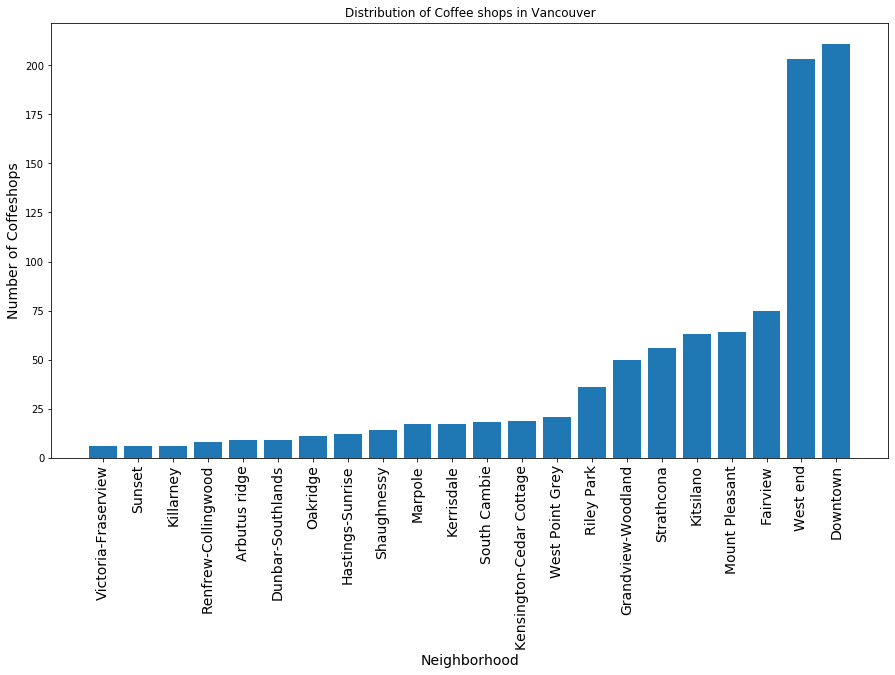

In [71]:
df_count_stores = df_neighbors.groupby('Neighborhood').count().sort_values("Name", ascending = True).reset_index()[['Neighborhood' ,'Name' ]]
df_count_stores.rename(columns = {'Name' : 'Number of Coffeshops'} , inplace = True)
#bar chart
plt.subplots(figsize=(15,8))
plt.bar(df_count_stores['Neighborhood'], df_count_stores['Number of Coffeshops'], data=df_count_stores )
plt.xticks(rotation=90 ,fontsize = 14)
plt.xlabel('Neighborhood',fontsize = 14) # add to x-label to the plot
plt.ylabel('Number of Coffeshops',fontsize = 14) # add y-label to the plot
plt.title('Distribution of Coffee shops in Vancouver') # add title to the plot

plt.show()

##### Now we need to get University and college area density in Vancouver by Foursquare

We are going to use College & University category id to create a similar data frame, but this time we will focus on venues and university distribution.


* 4d4b7105d754a06372d81259  College & University

In [31]:
CATEGORIES_UNI = ['4d4b7105d754a06372d81259']
df_uni = getNearbyVenues(df['Neighborhood'],CATEGORIES_UNI , df['Latitude'], df['Longitude'] )
df_uni.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Name,Venue Name,Venue Latitude,Venue Longitude,Venue Category
0,Arbutus ridge,49.240968,-123.167001,New Link College Vancouver,West Blvd,49.238154,-123.155573,University
1,Arbutus ridge,49.240968,-123.167001,Little House Educational Resource Center,Mackenzie st.,49.242417,-123.173583,General College & University
2,Arbutus ridge,49.240968,-123.167001,Kerrisdale Elementary,Carnarvon St,49.236140,-123.173581,College Academic Building
3,Arbutus ridge,49.240968,-123.167001,MindStory Coaching Academy,"1601, 100-535 Thurlow Street",49.242175,-123.153455,Student Center
4,Downtown,49.283393,-123.117456,The Dirty Apron Cooking School,Not Available,49.280693,-123.109393,Trade School


In [72]:
df_uni.groupby('Neighborhood').count().reset_index().sort_values("Name", ascending = False).head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Name,Venue Name,Venue Latitude,Venue Longitude,Venue Category
1,Downtown,100,100,100,100,100,100,100
21,West end,35,35,35,35,35,35,35
3,Fairview,17,17,17,17,17,17,17
17,Strathcona,11,11,11,11,11,11,11
11,Mount Pleasant,8,8,8,8,8,8,8


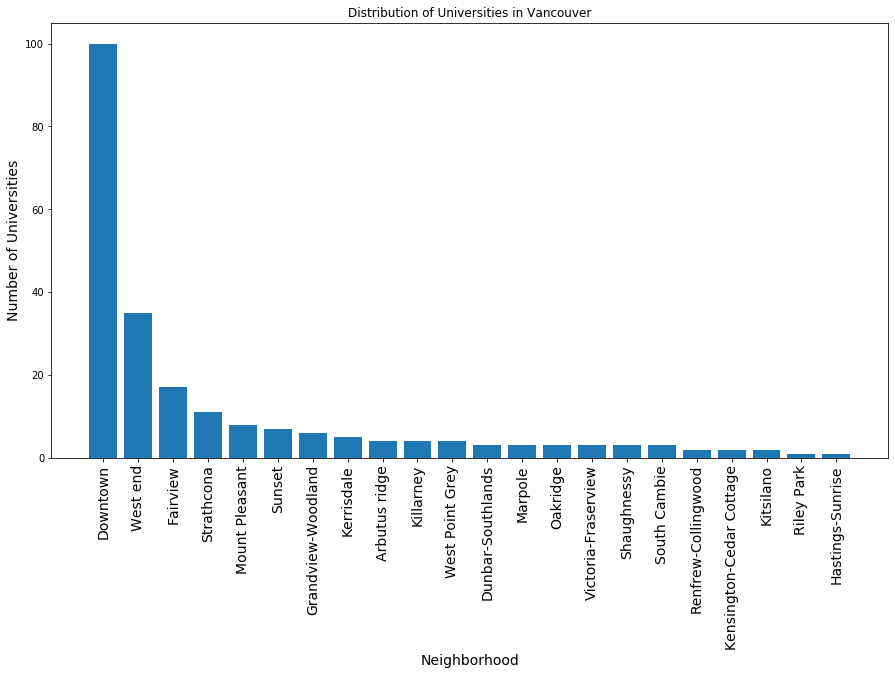

In [74]:
df_count_uni = df_uni.groupby('Neighborhood').count().sort_values("Name", ascending = False).reset_index()[['Neighborhood' ,'Name' ]]
df_count_uni.rename(columns = {'Name' : 'Number of Universities'} , inplace = True)
#bar chart
plt.subplots(figsize=(15,8))
plt.bar(df_count_uni['Neighborhood'], df_count_uni['Number of Universities'], data=df_count_uni )
plt.xticks(rotation=90 ,fontsize = 14)
plt.xlabel('Neighborhood',fontsize = 14) # add to x-label to the plot
plt.ylabel('Number of Universities',fontsize = 14) # add y-label to the plot
plt.title('Distribution of Universities in Vancouver') # add title to the plot

plt.show()

### C. Analyze 